In [1]:
import pandas as pd
import numpy as np

import lib.draw as draw
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors

from tqdm import tqdm

In [2]:
# Ajust to create denser maps
densityX, densityY = 1.5, 2.25

In [3]:
df = pd.read_csv('data/formated_data.csv').drop('Unnamed: 0', axis = 1)

In [4]:
df = df[df.success == 0]
df

,type,player,team,success,x,y,endX,endY,isShot,isGoal,...,cross,layOff,regularPlay,rebound,xrebound,yrebound,xdribble,ydribble,toFoul,toCorner
4,Pass,322849,2187,0,36.5,11.4,88.6,0.0,False,False,...,False,False,False,False,-1.0,-1.0,-1.0,-1.0,False,False
5,Pass,322850,2187,0,63.3,6.1,74.3,12.0,False,False,...,False,False,False,True,53.2,51.2,-1.0,-1.0,False,False
6,Pass,27817,2188,0,25.6,83.8,48.4,48.2,False,False,...,False,False,False,True,46.8,48.8,-1.0,-1.0,False,False
7,Pass,137387,2187,0,53.5,49.9,66.6,50.3,False,False,...,False,False,False,False,40.2,30.6,-1.0,-1.0,False,False
10,Pass,114597,2188,0,59.4,67.6,58.5,63.4,False,False,...,False,False,False,False,39.8,85.0,-1.0,-1.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243765,Pass,121988,108,0,33.6,24.3,63.7,83.0,False,False,...,False,False,False,False,61.6,80.3,-1.0,-1.0,False,False
243768,Pass,24030,297,0,81.2,9.2,84.5,28.3,False,False,...,True,False,False,True,68.6,21.0,-1.0,-1.0,False,False
243769,Pass,70617,108,0,9.4,87.5,38.7,66.9,False,False,...,False,False,False,False,0.9,40.0,-1.0,-1.0,False,False
243772,Pass,125793,297,0,69.2,94.7,96.1,55.5,False,False,...,True,False,False,False,31.7,46.4,-1.0,-1.0,False,False


# Generate gradients

In [5]:
def plot_xrmap(xrmap, fromX, fromY):
    draw.pitch()
    cmap = np.zeros((len(xrmap),4))
    cmap[:,0] = 1; cmap[:,1] = 1; cmap[:,2] = 1; cmap[:,3] = xrmap.xr
    plt.scatter(xrmap.x, xrmap.y, s = 15, c = cmap, marker = 's', linewidth=0, zorder = 10)
    plt.scatter(fromX, fromY, s = 15, c = 'purple', linewidth=0, zorder = 11)
    targets = xrmap[(xrmap.x == fromX) & (xrmap.y == fromY)]
    plt.scatter(targets.xtarget, targets.ytarget, s = 15, c = 'purple', marker = 's', linewidth=0, zorder = 11)
    plt.scatter(targets.xtarget + targets.dev_xx_xr, targets.ytarget + targets.dev_yy_xr, s = 30, c = 'purple', linewidth=0, zorder = 11)
    plt.scatter(targets.xtarget + targets.dev_xx_xr, targets.ytarget - targets.dev_yy_xr, s = 30, c = 'purple', linewidth=0, zorder = 11)
    plt.scatter(targets.xtarget - targets.dev_xx_xr, targets.ytarget + targets.dev_yy_xr, s = 30, c = 'purple', linewidth=0, zorder = 11)
    plt.scatter(targets.xtarget - targets.dev_xx_xr, targets.ytarget - targets.dev_yy_xr, s = 30, c = 'purple', linewidth=0, zorder = 11)

In [6]:
from statistics import stdev, mean

def calculate_xrmap(rebound_data, k=100):
    data = rebound_data[['x','y','xrebound','yrebound', 'rebound']]

    nn = NearestNeighbors(n_neighbors=k, n_jobs = -1)
    nn.fit(data[['x','y']], data['rebound'])

    xrmap = [[i, j] for i in np.arange(0, 100, densityX) for j in np.arange(0, 100, densityY)]
    xrmap = pd.DataFrame(xrmap, columns=['x', 'y'])

    estimated_xr = []
    target_x = []
    target_y = []
    dev_xx_xr = []
    dev_yy_xr = []
    for i, pixel in xrmap.iterrows():
        neighbors_dist, neighbors_ind = nn.kneighbors(pixel[['x', 'y']].to_numpy().reshape(1, -1))
        values = []
        xxs = []
        yys = []
        for n_dist, n_ind in zip(neighbors_dist[0], neighbors_ind[0]):
            instance = data.iloc[n_ind]
            values.append(instance['rebound'] * 1)
            xxs.append(instance['xrebound'])
            yys.append(instance['yrebound'])

        estimated_xr.append(sum(values)/len(values))
        target_x.append(sum(xxs)/len(xxs))
        target_y.append(sum(yys)/len(yys))
        dev_xx_xr.append(stdev(xxs))
        dev_yy_xr.append(stdev(yys))

    xrmap['xr'] = estimated_xr
    xrmap['xtarget'] = target_x
    xrmap['ytarget'] = target_y
    xrmap['dev_xx_xr'] = dev_xx_xr
    xrmap['dev_yy_xr'] = dev_yy_xr

    return xrmap

In [7]:
np.arange(0, 100, densityX), np.arange(0, 100, densityY)

(array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ,
        16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5,
        33. , 34.5, 36. , 37.5, 39. , 40.5, 42. , 43.5, 45. , 46.5, 48. ,
        49.5, 51. , 52.5, 54. , 55.5, 57. , 58.5, 60. , 61.5, 63. , 64.5,
        66. , 67.5, 69. , 70.5, 72. , 73.5, 75. , 76.5, 78. , 79.5, 81. ,
        82.5, 84. , 85.5, 87. , 88.5, 90. , 91.5, 93. , 94.5, 96. , 97.5,
        99. ]),
 array([ 0.  ,  2.25,  4.5 ,  6.75,  9.  , 11.25, 13.5 , 15.75, 18.  ,
        20.25, 22.5 , 24.75, 27.  , 29.25, 31.5 , 33.75, 36.  , 38.25,
        40.5 , 42.75, 45.  , 47.25, 49.5 , 51.75, 54.  , 56.25, 58.5 ,
        60.75, 63.  , 65.25, 67.5 , 69.75, 72.  , 74.25, 76.5 , 78.75,
        81.  , 83.25, 85.5 , 87.75, 90.  , 92.25, 94.5 , 96.75, 99.  ]))

In [8]:
xrmap = calculate_xrmap(df)
xrmap.to_csv('matrix/R.csv')

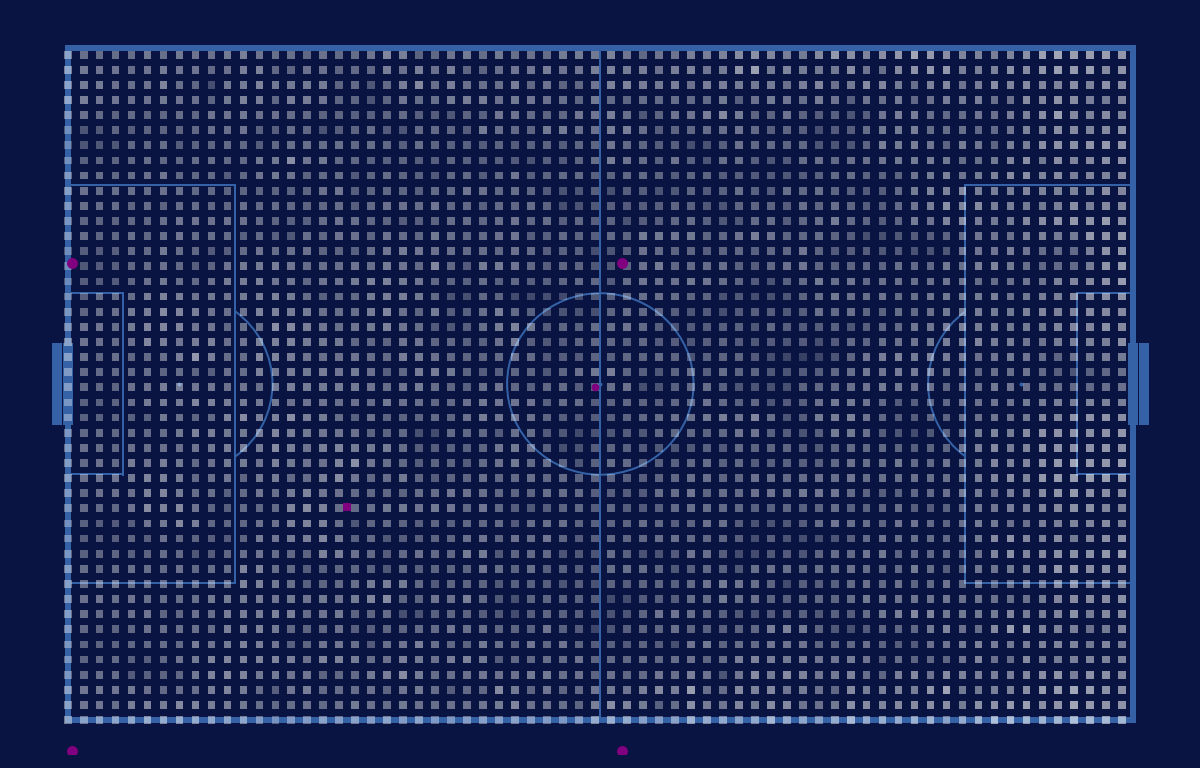

In [9]:
plot_xrmap(xrmap, 49.5, 49.5)

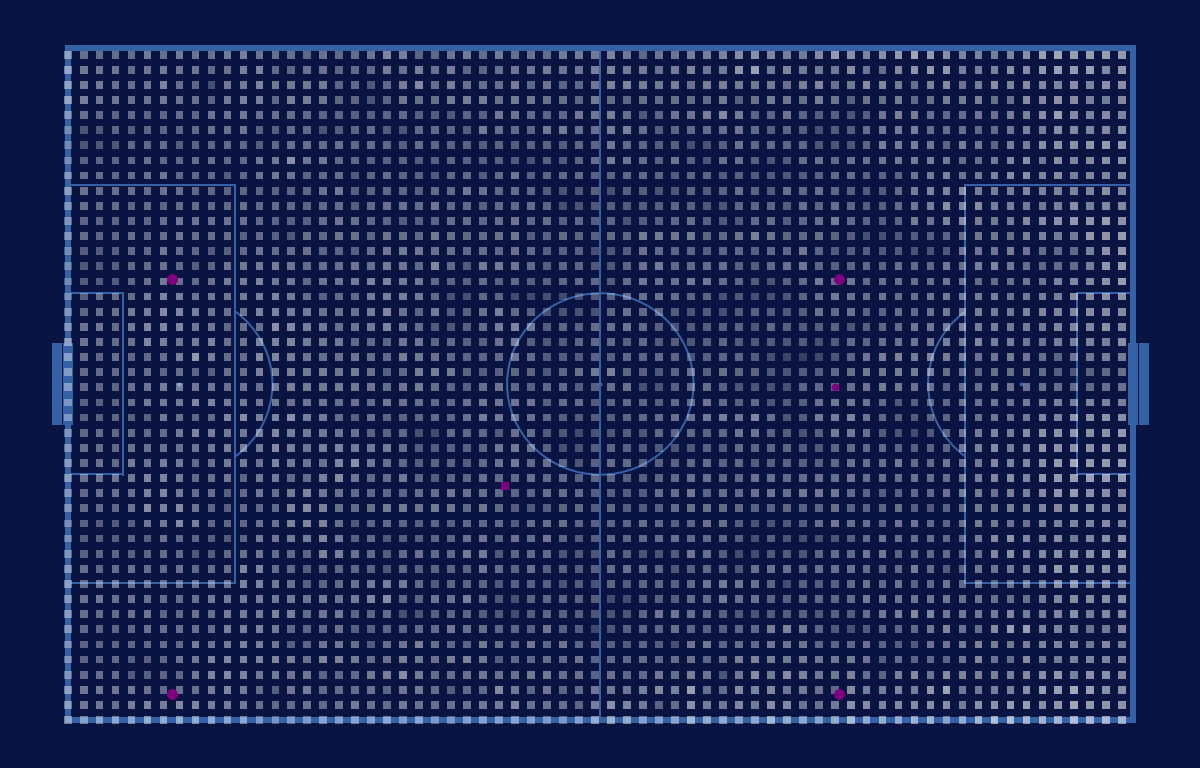

In [10]:
plot_xrmap(xrmap, 72, 49.5)

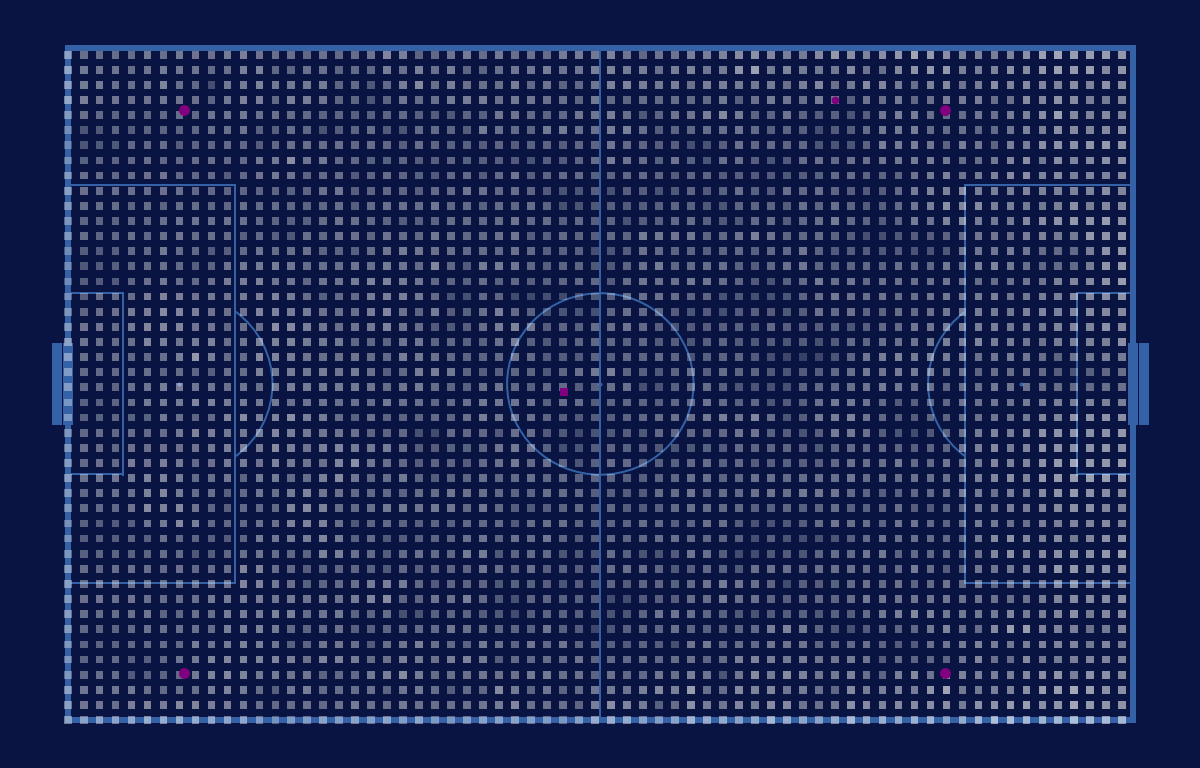

In [11]:
plot_xrmap(xrmap, 72, 92.25)